This notebook showcases the calculation of enstrophy Probability Distribution Function (PDF) from the Hopkins Turbulence Database. It also demonstrates the calculation of the power spectrar of the excursion set of enstrophy based on the caracteristic function of thresholded sets, for different enstrophy thresholds.

It is necessary, firstly, to execute the commented command on a separate notebook, to enable the parallel execution enviroment, and the following command to allow this notebook to execute in the corresponding enviroment.

In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')


Following suit, it is necessary to import the libraries that are necessary to the work to be executed. These include  numpy for the generay array manipulations, pyFFTW to the Fourier Transforms, mpi4py for MPI support, general math, sys and os libraries and pyJHTDB, that provides a python wraper for the C-SOAP interface of the Johs Hopkins Turbulence Databases. We also import some modules that provide basic 3D FFT and histograming functionality build upon numpy and pyFFTW, as a way to streamline the overall process. Those modules, which include FFT3Dfield, IFFT3Dfield and EnergySpectrum, were originaly developed by Dr. Kun Yang.

In [2]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from FFT3Dfield import FFT3Dfield
from IFFT3Dfield import IFFT3Dfield
from EnergySpectrum import EnergySpectrum

We first initialize general domain constants, based on the isotropic1024coarse dictionary, which provide information on the isotropic turbulence database.

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

We then initialize MPI variables, including the communicator, rank and number of process. The typical number of processes is 8, both because it doesn't, usually, overloads the sciserver hardware, but also it is the optimal number of processes to query the database. 

In [4]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

[stdout:4] 
n_proc = 8
rank = 0


Afterwards, it is necessary to initalize the variables that designate the domain associated with each MPI process. Due to the way that the FFT3D modules were build, we chose to divide the domain in slabs split in the X direction. Also, constants related to wavenumber and chunck size downloads are initialized.

In [5]:
%%px 
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

Here is the data loading part. It can be chosen to be one of two ways. In case there is a previously cached data in disk, it can be read directly without the need to download from the database. In this case, we supose that the data is stored in numpy array binary data, ".npz". Because of the way pyFFTW works, each component must be stored separately, therefore we initialize vx, vy and vz arrays as appropiate for the FFTW work, which is aligned arrays. Typical loading time from disk range from 20 to 60 seconds. 

In case the data has not been previously cached, it is necessary to download from the database. Due to constraints in the workings of the database itself, there is a maximum size that can be queried on a single function call, consequently, it is necessary to break the download into several queries, which can be described as follows: For a whole $1024^3$ download, each slab contained in a process is of size $128 \times 1024 \times 1024$, and each query is of size $32 \times 1024 \times 1024$, the data is stored temporarely in a list, then concatenated and than reshaped (via np.transpose) to be properly assigned to the vx, vy and vz vectors. As a precaution, the data is cached as soon as the final vectors are calculated. This notebook only calculates a single time-step, but it can be readly generalized to be used with a list of timesteps instead. Typical download times range from 170 to 250 seconds, inside sciserver.

In [6]:
%%px

vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True

folder = "/home/idies/workspace/scratch"
filename = "cache-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    lJHTDB = libJHTDB()
    lJHTDB.initialize()
    ud = []
    for k in range(slabs):
        if(rank==0):
            print(k)
        start = np.array([rank*nx+k*chkSz, 0, 0],dtype=np.int)
        width = np.array([chkSz,ny,nz],dtype=np.int)
        #start = np.array([ 0, 0, rank*nx+k*chkSz],dtype=np.int)
        ud.append(lJHTDB.getRawData(time,start,width, 
                                    data_set = 'isotropic1024coarse',
                                    getFunction = 'Velocity') )
    
    lJHTDB.finalize()
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    u = np.concatenate(ud,axis=2)
    comm.Barrier(); t1=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Concatenate: {0:.2f} seconds\n'.format(t1-t2))
    
    rsh = np.transpose(u,(2,1,0,3))
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Transpose: {0:.2f} seconds\n'.format(t2-t1))
    ##########################################
    
    vx[:,:,:] = rsh[:,:,:,0]
    vy[:,:,:] = rsh[:,:,:,1]
    vz[:,:,:] = rsh[:,:,:,2]
    comm.Barrier(); t1=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Splitting: {0:.2f} seconds\n'.format(t2-t1))
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:4] 
Starting the loading process
Finished loading
Load from disk: 9.51 seconds
vx shape = (128, 1024, 1024)


The following step is to calculate the appropiate wavenumbers to be used. These are stored in the kx, ky, kz and k2 for the moduli square. Tipical calculation times range from 20 to 45 seconds. 

In [7]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,rank)
k2=np.zeros((nx,ny,nz_half+1), dtype='float32')
np.copyto(k2,kx*kx+ky*ky+kz*kz)
k2[0,0,0]=1e-6

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate all wavenumbers: 10.08 seconds


Here is the step where the 3D FFT are calculated over the vx, vy and vz vectors. Since the initial data is real, only $128 \times 1024 \times 513$ components are stored, matching the corresponding wavenumbers calculated previously. Typical calculation times range from 70 to 120 seconds.

In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cvx=myFFT3Dfield.GetFFT3Dfield(vx,nx,ny,nz,nproc,rank)
cvy=myFFT3Dfield.GetFFT3Dfield(vy,nx,ny,nz,nproc,rank)
cvz=myFFT3Dfield.GetFFT3Dfield(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial FFT: 75.20 seconds


With the data of the Fourier components of the velocity field, it is possible to calculate the vorticity algebraically, using spectral derivatives. These amount to $\partial_j \rightarrow i k_j$, and these enable us to calculate derivatives with high accuracy, the requirement being that the data must be originally from a regularly spaced grid, which is the case of the isotropic turbulence database. Typical calculation times range from 20 to 80 seconds.

In [9]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cwx=np.complex64(0.0+1.0j)*(ky*cvz-kz*cvy)
cwy=np.complex64(0.0+1.0j)*(kx*cvz-kz*cvx)
cwz=np.complex64(0.0+1.0j)*(kx*cvy-ky*cvx)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate vorticity in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate vorticity in k space: 25.09 seconds


In order to calculate enstrophy, it is necessary to return to real space, to do the multiplication of the real components, we follow buy calculating a inverse 3D FFT. Typical calculation times range from 80 to 130 seconds. 

In [11]:
%%px

miFFT3Dfield=IFFT3Dfield()

tv=ft.zeros_aligned((nx,ny,nz), dtype='float32')
tcvt=ft.zeros_aligned((nx,ny,nz_half+1), dtype='complex64')

wx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
wy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
wz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [35]:
%%px 

cwx[kz==(Nz//2)] = 0.
cwy[kz==(Nz//2)] = 0.
cwz[kz==(Nz//2)] = 0.

In [36]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:


wx[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(cwx,tv,tcvt,nx,ny,nz,nproc,rank)
wy[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(cwy,tv,tcvt,nx,ny,nz,nproc,rank)
wz[:,:,:]=miFFT3Dfield.GetIFFT3Dfield(cwz,tv,tcvt,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial inverse FFT: 80.11 seconds


The enstrophy $\omega^2$, stored in w2, is calculated as the sum of ${\bf \omega}^2 = \omega_x^2 + \omega_y^2 + \omega_z^2$, and the average enstrophy over the spatial domain, $\langle \omega^2\rangle$, is stored in sigma2_w. This is an important measure and serves as future reference, when we calculate the enstrophy Probability Distribution Function (PDF). The calculation of the average is done separately in each slab, and then must be reduced to be calculated the global average, and afterwards broadcast again to all processes. Typical calculation times range from 10 to 30 seconds.

In [38]:
%%px
comm.Barrier(); t1=MPI.Wtime()

#wmod = (wx**2+wy**2+wz**2)**0.5
w2   = (wx**2+wy**2+wz**2)
sigma2_w = np.average(w2)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate average enstrophy: {0:.2f} seconds\n'.format(t2-t1))


[stdout:4] Calculate average enstrophy: 12.60 seconds


In [39]:
%%px

cacheEnstrophyData = True
loadEnstrophyFromCache = False

folder = "/home/idies/workspace/scratch"
filename = "enstrophy-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Caching the data: 283.24 seconds


This section does the reduction of all averaged in the first process, calculate the global average, and then broadcasts again to all processes'. The global average found was $\langle \omega^2 \rangle = 233.112$. The list of slab averages is $[259.28671, 237.5885, 206.27568, 199.08809, 234.72603, 216.47806, 257.14105, 254.31326]$.

In [40]:
%%px
comm.Barrier()
sw2 = []
if(rank==0):
    sw2.append(sigma2_w)
    for j in range(1,nproc):
        sigma2_r = comm.recv(source=j,tag=11)
        sw2.append(sigma2_r)
else:
    comm.send(sigma2_w,dest=0,tag=11)
    
comm.Barrier()
sigma2g = 0
if(rank==0):
    print(sw2)
    sigma2 = np.average(np.array(sw2))
    #print(sigma2)
    sigma2g = sigma2#**0.5
    print("RMS vorticity = \omega_{rms}^2 = "+str(sigma2g)+" s^{-2}")
    for j in range(1,nproc):
        comm.send(sigma2g,dest=j,tag=11)
else:
    sigma2g = comm.recv(source=0,tag=11)
    
comm.Barrier()

[stdout:4] 
[406.36383, 373.12405, 322.50803, 310.28836, 367.62122, 339.15222, 402.95297, 400.1763]
RMS vorticity = \omega_{rms}^2 = 365.273 s^{-2}


The process is repeated in order to find global maxima and minima of $\omega^2$.

In [41]:
%%px
comm.Barrier()
minw2 = w2.min()
maxw2 = w2.max()

Again, the calculations are reduced from all processes. 

In [42]:
%%px
comm.Barrier()

minwl = []
if(rank==0):
    minwl.append(minw2)
    for j in range(1,nproc):
        minw_r = comm.recv(source=j,tag=11)
        minwl.append(minw_r)
else:
    comm.send(minw2,dest=0,tag=11)

comm.Barrier()

maxwl = []
if(rank==0):
    maxwl.append(maxw2)
    for j in range(1,nproc):
        maxw_r = comm.recv(source=j,tag=11)
        maxwl.append(maxw_r)
else:
    comm.send(maxw2,dest=0,tag=11)

comm.Barrier()

if(rank==0):
    m = min(minwl)
    M = max(maxwl)


And broadcast back to all processes.

In [43]:
%%px
if(rank==0):
    for j in range(1,nproc):
        comm.send(m,dest=j,tag=22)
else:
    m=comm.recv(source=0,tag=22)
    
comm.Barrier()

if(rank==0):
    for j in range(1,nproc):
        comm.send(M,dest=j,tag=22)
else:
    M=comm.recv(source=0,tag=22)

The minimum and maximum values obtained are $\min\ \omega^2/\langle \omega^2\rangle = 9.42509 \times 10^{-10}$ and $\max\ \omega^2/\langle \omega^2\rangle = 459.398$. Later $\min\ \omega^2/\langle \omega^2\rangle = 9.33189 \times 10^{-8}$ and $\max\ \omega^2/\langle \omega^2\rangle = 460.222$

In [44]:
%%px

if(rank==0):
    print("rank= "+str(rank))
    print("minw = "+str(m/sigma2g))
    print("maxw = "+str(M/sigma2g))

[stdout:4] 
rank= 0
minw = 9.33189e-08
maxw = 460.222


The values of minimum, maximum and average are used to prepare a normalized histogram of the enstrophy over the whole domain, which can be, afterwards, be converted to the estimated PDF. Again, the calculation is done in each slab and then reduced to the 0-th process, which will be used to do all the plots. 

In [45]:
%%px
Nbins = 3200
w2histo=np.zeros(Nbins,dtype='int')
hist,edges = np.histogram(w2/sigma2g,np.linspace(m/sigma2g, M/sigma2g, Nbins))
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

The reduction must be done in blocks, at least it was the way I managed to do it. 

In [46]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([hist[i*100:(i+1)*100],MPI.INT],[w2histo[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

We can, with this resulting histogram, plot the (un-normalized) PDF of enstrophy.

[output:4]

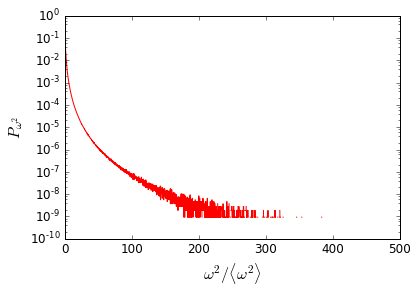

In [47]:
%%px
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
w2histo[-1] = 0
if rank==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')

    plt.semilogy(edges,(w2histo)*(1024**(-3)),'r',label='Unfiltered')

Is is possible to zoom in the (normalized) enstrophy PDF, in the $[0,100]$ range of $\frac{\omega^2}{{\langle \omega^2\rangle}}$.

[output:4]

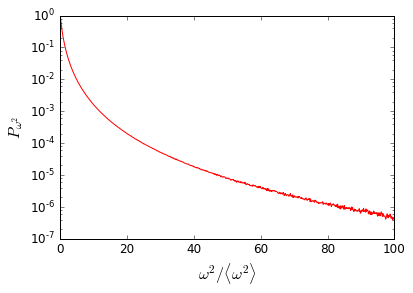

In [28]:
%%px

%matplotlib inline
w2histo[-1] = 0
if rank==0:
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    plt.xlim(0,100)
    plt.ylim(10**(-7),10**(0))

    plt.semilogy(edges,w2histo*(1024**(-3))/((M-m)/(sigma2g*Nbins)),'r',label='Unfiltered')

This process can be repeated again for smaller intervals, which is usefull for comparison with previous data. Here we focus on the $[0,20]$ range of $\frac{\omega^2}{{\langle \omega^2\rangle}}$.

In [29]:
%%px
Nbins = 400
wtemp = w2[w2<=20*sigma2g] 
w2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(wtemp/sigma2g,np.linspace(m/sigma2g, 20, Nbins))
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [30]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:4]

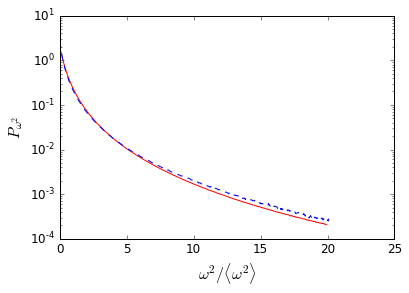

In [31]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(w2red*(1024**(-3)))/((20*sigma2g-m)/(sigma2g*Nbins)),'r',label='Unfiltered')
    plt.semilogy(w2_bins,w2_pdf,'b--')

And a final zoom in, in $[0,5]$ range.

In [51]:
%%px
Nbins = 800
wtemp = w2[w2<=5*sigma2g] 
w2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(wtemp/sigma2g,np.linspace(m/sigma2g, 5, Nbins))
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [52]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:4]

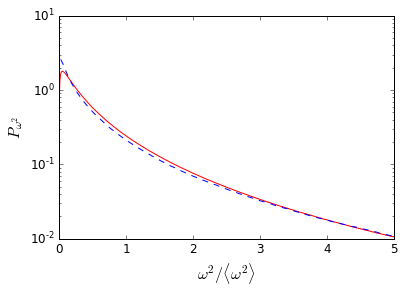

In [53]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')

    plt.semilogy(edgesred,(w2red*(1024**(-3)))/((5*sigma2g-m)/(sigma2g*Nbins)),'r',label='Unfiltered')
    plt.semilogy(w2_bins[w2_bins<=5],w2_pdf[w2_bins<=5],'b--')

We proceed to calculate the caracteristic function of the excursion sets. This means functions of the form $\chi_t(x) = 1\ {\rm if}\ \omega^2 > t ,\ 0\ {\rm otherwise}$. This is done by initializing an aligned numpy array, clean all values to zero and then set the appropiate values to one. For the Initial test, we utilized $t=20 \langle \omega^2 \rangle$.

In [31]:
%%px

chi = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [32]:
%%px

chi[:,:,:] = 0
chi[w2 > 20*sigma2_w] = 1

To calculate the power spectrum, and then, from it, calculate the 2-point correlation function of the thresholded set characteristic function, we need to Fourier transform the data, pointwise multiply the resulting array in wavenumber space, and then integrate over the sphere, leaving the results as a function of $k=\sqrt{{\bf k}^2}$. The first step is calculate the Fourier transform of $\chi$.

In [33]:
%%px 

comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:
myFFT3Dfield=FFT3Dfield()
cchi=myFFT3Dfield.GetFFT3Dfield(chi,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:4] Calculate 3D spatial FFT: 37.68 seconds


The procedure in Fourier transform is, first, calculate $\tilde{\chi}\tilde{\chi}^*$, where $\tilde{\chi}=\mathfrak{F}(\chi)$ is the fourier transform of the characteristic function of the tresholded set. To perform the angular integration, the procedure is to mimick what was done to calculate the energy spectra, using the histogram on $\sqrt{{\bf k}^2}$ with weights of $\tilde{\chi}\tilde{\chi}^*({\bf k})$ to do the calculation. This procedure amounts to calculate the integral of the solid angle over the sphere $S^2$. Again, the calculations are done in each slab and then reduced to the first process. 

In [34]:
%%px
tmp = (cchi*cchi.conj()).real
ekbins=np.linspace(0.5,nek+0.5,nek+1)
k2rt=np.sqrt(k2)

chi2loc,kedges=np.histogram(k2rt,range=(0.5,nek+0.5),bins=ekbins,weights=tmp)

del k2rt
del tmp

chi2loc=np.float32(chi2loc)
chi2sum=np.zeros(nek,dtype='float32')

comm.Reduce([chi2loc,MPI.REAL],[chi2sum,MPI.REAL],op=MPI.SUM)

chi2k=np.zeros(nek,dtype='float32')
np.copyto(chi2k,chi2sum)

We can proceed to plot the graph of the resulting power spectra, which can be seen below. The descending tail can be fit, locally, with a power law with slope $-0.7$.

[output:4]

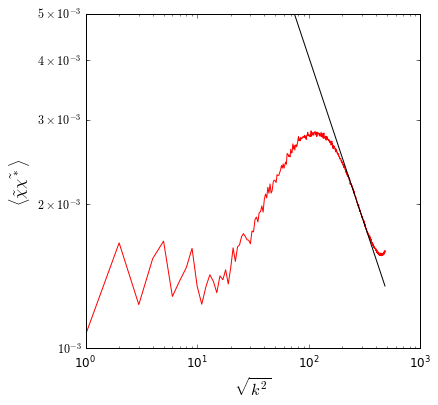

In [42]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    norm = np.sum(chi2k)
    SIZE = 12
    ks=np.linspace(1,nek,nek)
    plt.figure(figsize=(6,6))
    plt.ylim(10**(-3),10**(-2.5))
    plt.xlabel(r'$\sqrt{k^2}$')
    plt.ylabel(r'$\langle\tilde{\chi}\tilde{\chi^*}\rangle$')
    
    plt.loglog(ks,chi2k/norm,'r',label='Unfiltered')
    #plt.loglog(ks,0.065*np.power(ks,-0.62),'k')
    plt.loglog(ks,0.102*np.power(ks,-0.7),'k')
    
    #plt.xticks([100,200,300,400,500], [r'$10^2$',r'$2 \times 10^2$',r'$3\times 10^2$',r'$4\times 10^2$',r'$5\times 10^2$'])
    plt.yticks([0.001,0.002,0.003,0.004,0.005], [r'$10^{-3}$',r'$2 \times 10^{-3}$',r'$3\times 10^{-3}$',r'$4\times 10^{-3}$',r'$5\times 10^{-3}$'])

The same graph, but zoomed in the region of the power law. 

[output:4]

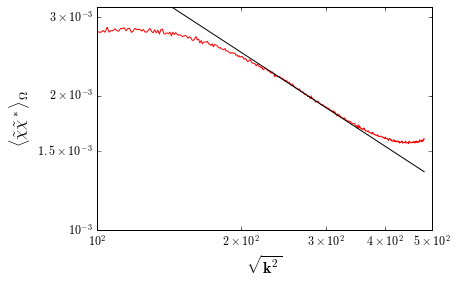

In [45]:
%%px

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

if rank==0:
    SIZE = 12
    norm = np.sum(chi2k)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)  
    ks=np.linspace(1,nek,nek)
    #ax.set_xticks(np.arange(100,500,10))
    
    plt.xlim(10**(2),0.5*10**(3))
    plt.ylim(10**(-3),10**(-2.5))
    plt.xlabel(r'$\sqrt{{\bf k}^2}$')
    plt.ylabel(r'$\langle\tilde{\chi}\tilde{\chi}^*\rangle_{\Omega}$')

    plt.loglog(ks,chi2k/norm,'r',label='Unfiltered')
    plt.loglog(ks,0.102*np.power(ks,-0.7),'k')
    
    plt.xticks([100,200,300,400,500], [r'$10^2$',r'$2 \times 10^2$',r'$3\times 10^2$',r'$4\times 10^2$',r'$5\times 10^2$'])
    plt.yticks([0.001,0.0015,0.002,0.003], [r'$10^{-3}$',r'$1.5\times 10^{-3}$',r'$2 \times 10^{-3}$',r'$3\times 10^{-3}$'])